In [13]:
# Imports
import os
import numpy as np
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

img_rows, img_cols = 64, 64
train_data_dir = './dataset/train'
validation_data_dir = './dataset/validation'

In [14]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 2
batch_size = 64

In [15]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [16]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 8000
num_validation_samples: 2000


In [17]:
def entry_flow(inputs):

    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728]:

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x


In [18]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [19]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    #x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    return x

In [20]:
inputs = Input(shape=(img_rows, img_cols, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

2021-10-20 22:29:18.305371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 22:29:18.909496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [21]:
xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
opt = tensorflow.keras.optimizers.Adam()
xception.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [23]:
history_1= xception.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-20 22:29:19.890278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-20 22:29:23.838225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-20 22:29:25.129243: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 22:29:25.154988: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 22:29:25.173102: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

125/125 [==============================] - 35s 232ms/step - loss: 0.0674 - accuracy: 0.9808 - val_loss: 1.5729 - val_accuracy: 0.4960
Epoch 2/30
125/125 [==============================] - 29s 231ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 2.1232 - val_accuracy: 0.4960
Epoch 3/30
125/125 [==============================] - 28s 226ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 4.5957 - val_accuracy: 0.4960
Epoch 4/30
125/125 [==============================] - 29s 229ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 1.3542 - val_accuracy: 0.6658
Epoch 5/30
125/125 [==============================] - 29s 228ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.4125 - val_accuracy: 0.9521
Epoch 6/30
125/125 [==============================] - 28s 224ms/step - loss: 0.0102 - accuracy: 0.9980 - val_loss: 0.0196 - val_accuracy: 0.9934
Epoch 7/30
125/125 [==============================] - 28s 223ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0111 - val_accuracy: 0.9

In [24]:
import seaborn as sns

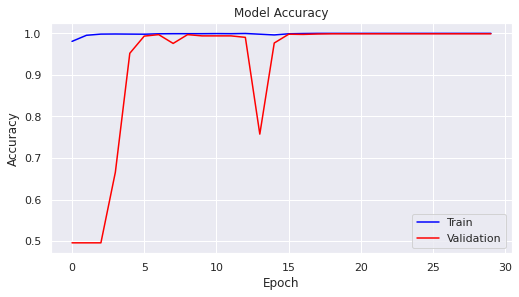

In [25]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], color="blue")
plt.plot(history_1.history['val_accuracy'] , color="red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_accuracy_raw_1.svg')


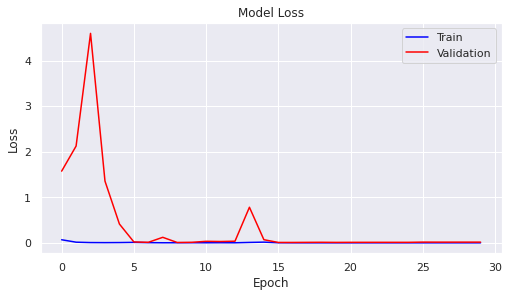

In [26]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], color="blue")
plt.plot(history_1.history['val_loss'], color="red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_loss_raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/Com_loss18.png')

In [27]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
batch_size=64

In [29]:
Y_pred = xception.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['Cracked', 'Non-Cracked']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(2000, 2)
              precision    recall  f1-score   support

     Cracked      1.000     0.998     0.999      1000
 Non-Cracked      0.998     1.000     0.999      1000

    accuracy                          0.999      2000
   macro avg      0.999     0.999     0.999      2000
weighted avg      0.999     0.999     0.999      2000



In [30]:
cm = confusion_matrix(y_true, y_pred)

In [31]:
classes=2

In [32]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [33]:
import imp
imp.reload(sns)

<module 'seaborn' from '/home/nsssayom/.local/lib/python3.9/site-packages/seaborn/__init__.py'>

In [34]:
sns.reset_defaults()

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

Confusion matrix, without normalization
[[ 998    2]
 [   0 1000]]


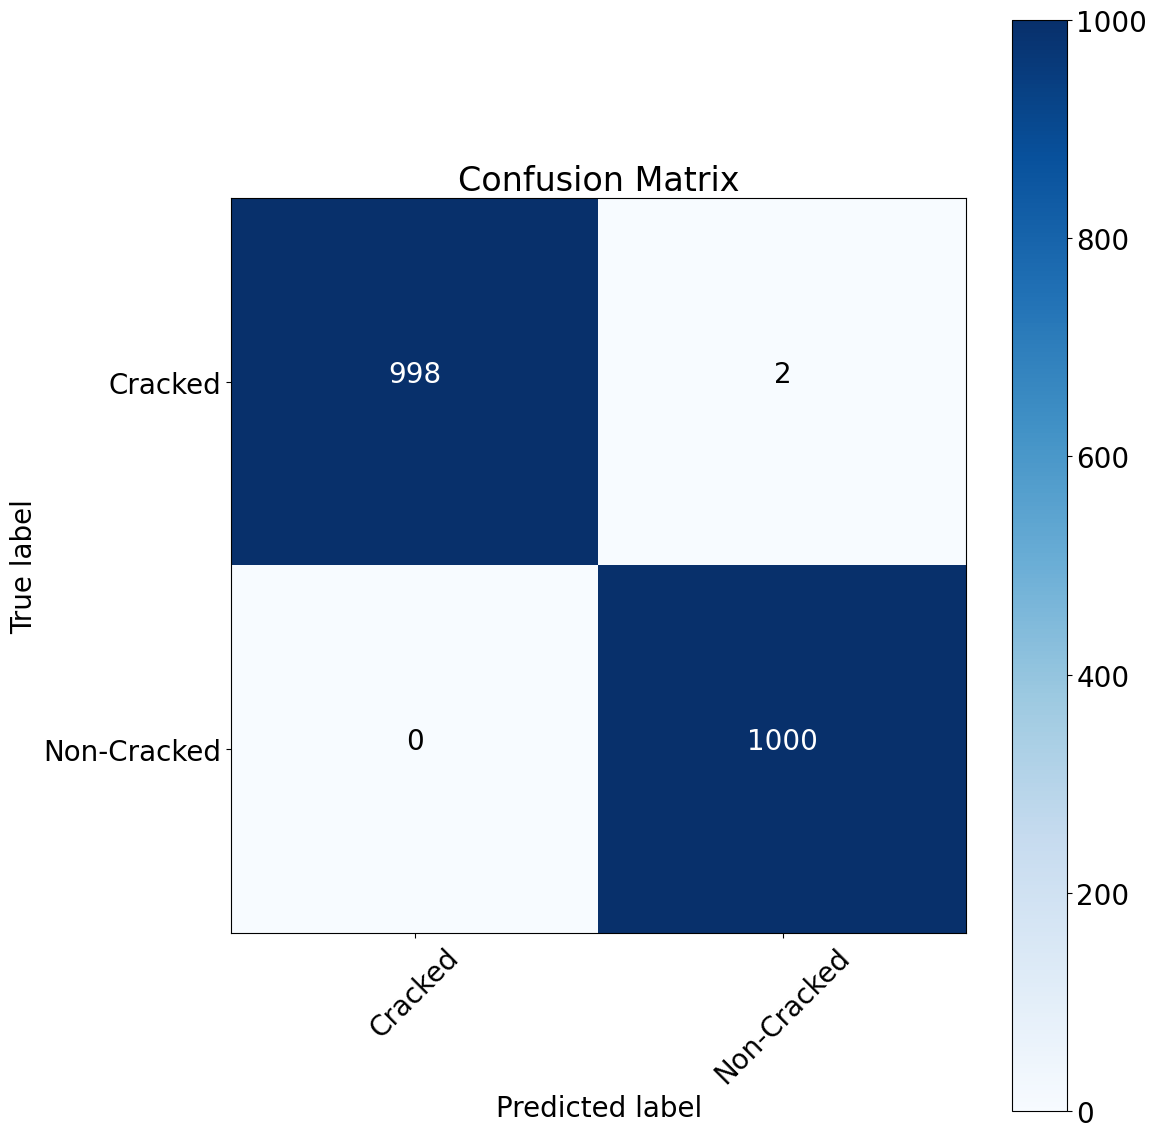

In [36]:
plt.rcParams.update({'font.size': 20})
cm_plot_labels = ['Cracked', 'Non-Cracked']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('./graph/TwoClass_conf_Raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/cf_val_git_05.png')
